In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seed-from-uci/Seed_Data.csv


I worked on this after completing the Datacamp course - 'Unsupervised Learning in Python'. All the techniques explained in that course are tried out in this notebook

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, MaxAbsScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, NMF
from mpl_toolkits.mplot3d import Axes3D

In [4]:
wheats = pd.read_csv("/kaggle/input/seed-from-uci/Seed_Data.csv")
wheats = wheats.rename(columns={"target":"label"})
wheats.head()

,A,P,C,LK,WK,A_Coef,LKG,label
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,0


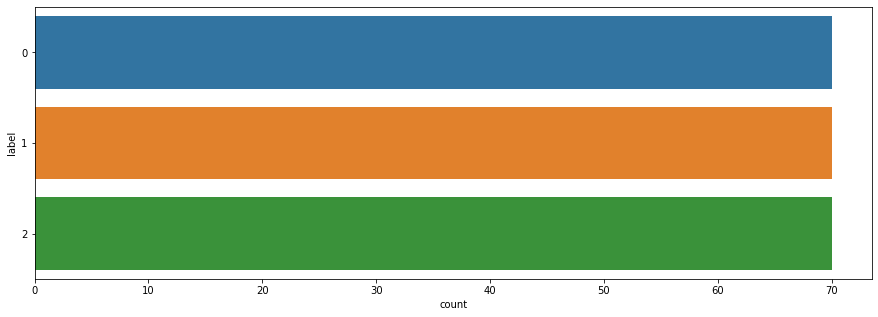

In [7]:
#Data Visualization - Label - countplot
fig,ax =  plt.subplots(figsize = (15 , 5))
sns.countplot(y = 'label' , data = wheats)
plt.show()

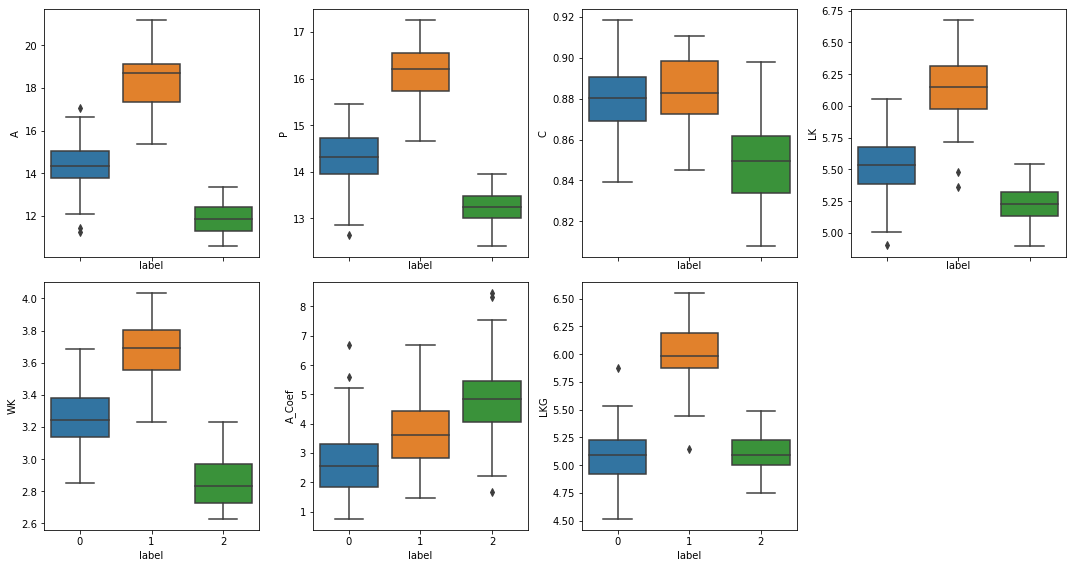

In [9]:
#Data Visualozation - Label vs other continuous variables - box plot
fig, axs = plt.subplots(ncols = 4, nrows = 2, figsize=(15,8),sharex=True)
for axi,col_name in zip(axs.flat,list(wheats.columns)):
    sns.boxplot(x="label",y=col_name,data=wheats,ax=axi)
fig.delaxes(ax = axs[1,3])
fig.tight_layout()
fig.show()

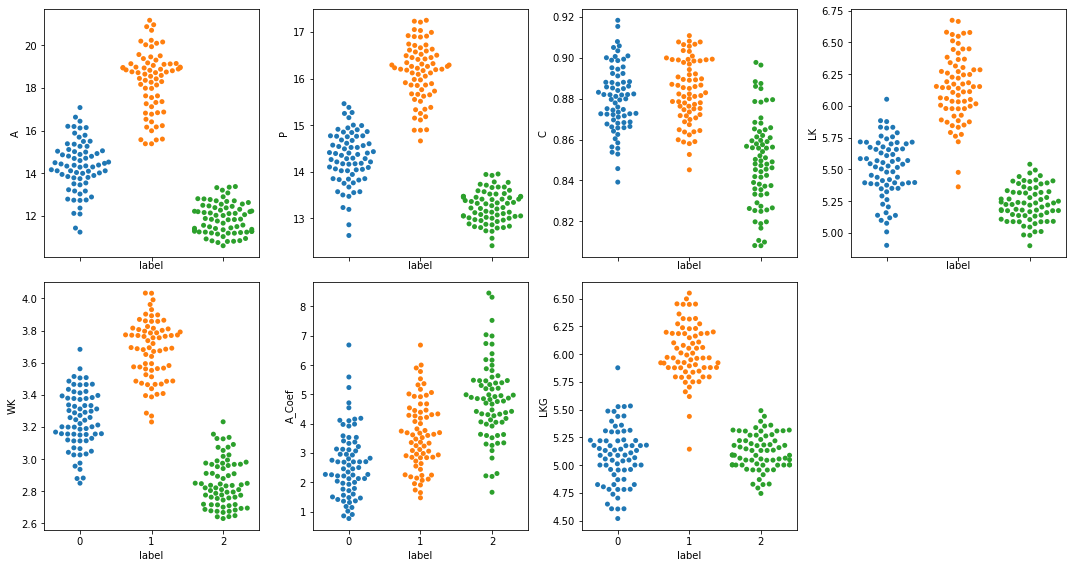

In [10]:
#Data Visualozation - Label vs other continuous variables - swarmplot
fig, axs = plt.subplots(ncols = 4, nrows = 2, figsize=(15,8),sharex=True)
for axi,col_name in zip(axs.flat,list(wheats.columns)):
    sns.swarmplot(x="label",y=col_name,data=wheats,ax=axi)
fig.delaxes(ax = axs[1,3])
fig.tight_layout()
fig.show()

From the above graphs we can see that there is a good segregation between variables. But many variables have a similar distribution in terms of labels. We can use techniques like PCA to reduce dimensions without losing information

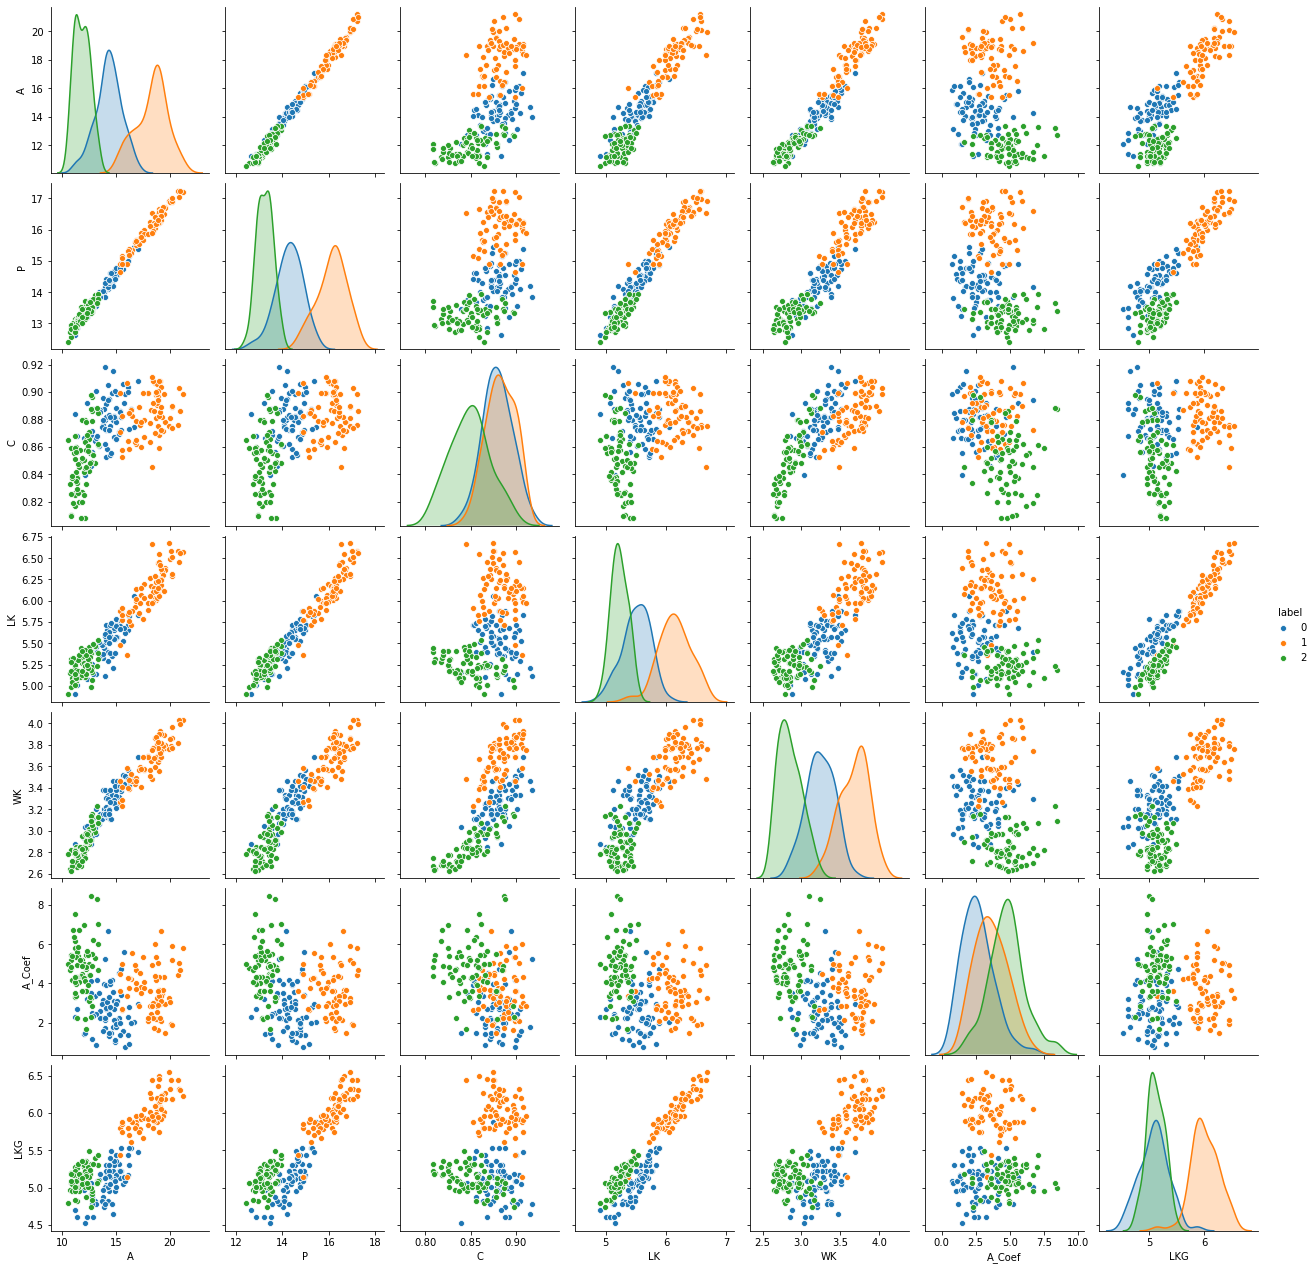

In [11]:
#Data Visualization - Continuous Variables - pairplot
sns.pairplot(data=wheats,hue="label")

We can see from the above graph that Area, Perimeter, Kernel Length, Kernel Width and Kernel groove length have similar distributions

Let's check using a correlation heat map

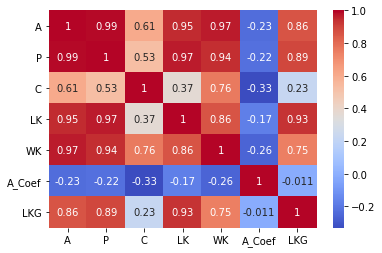

In [12]:
#Data Visualization - Continuous Variables - heatmap (Area, Compactness, Assymetry Coefficient)
sns.heatmap(wheats[list(wheats.columns[:-1])].corr(),annot=True,cmap="coolwarm")
plt.show()

From the above heatmap, we can tell that only assymetry coefficient is different from other variables.

# K-Means Clustering

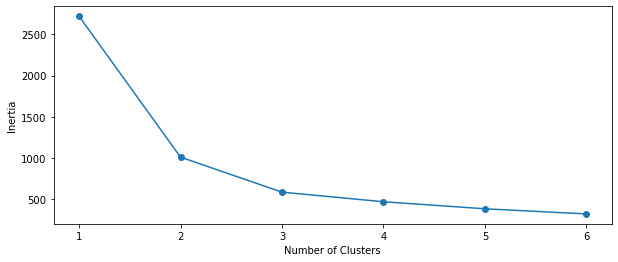

In [15]:
#KMeans Clustering - Optimal number of clusters
inertia = []
for c in range(1,7):
    model = KMeans(n_clusters=c)
    model.fit(wheats[list(wheats.columns[:-1])])
    inertia.append(model.inertia_)
fig, ax = plt.subplots(figsize = (10 ,4))
ax.plot(np.arange(1 , 7) , inertia , marker="o")
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')
fig.show()

3 is the optimal number of clusters. After 3, the reduction in inertia is insignificant

In [16]:
#KMeans Clustering - Validation
model = KMeans(n_clusters = 3)
model.fit(wheats[list(wheats.columns[:-1])])
label_pred = model.predict(wheats[list(wheats.columns[:-1])])
wheat_preds = pd.DataFrame({"label_act":list(wheats["label"]),"label_kmeans":list(label_pred)})
pd.crosstab(wheat_preds.label_act,wheat_preds.label_kmeans)

label_kmeans,0,1,2
label_act,,,
0,9,1,60
1,0,60,10
2,68,0,2


We are able to segregate 188 out of 210 correctly. To improve this we can standardize data so that mean is 0 and variance is 1

In [17]:
#k-Means Clustering - Standardisation
scaler = StandardScaler()
kmeans = KMeans(n_clusters=3)
pipeline = make_pipeline(scaler,kmeans)
pipeline.fit(wheats[list(wheats.columns[:-1])])
labels_pred_std = pipeline.predict(wheats[list(wheats.columns[:-1])])
wheat_preds["labels_kmeans_std"] = labels_pred_std
pd.crosstab(wheat_preds.label_act,wheat_preds.labels_kmeans_std)

labels_kmeans_std,0,1,2
label_act,,,
0,62,6,2
1,5,0,65
2,4,66,0


After standardisation, 193 samples are grouped correctly compared to 188 without standardisation

# Hierarchical Clustering - Agglomerative

In [18]:
samples = np.array(wheats[list(wheats.columns[:-1])])
samples.shape

(210, 7)

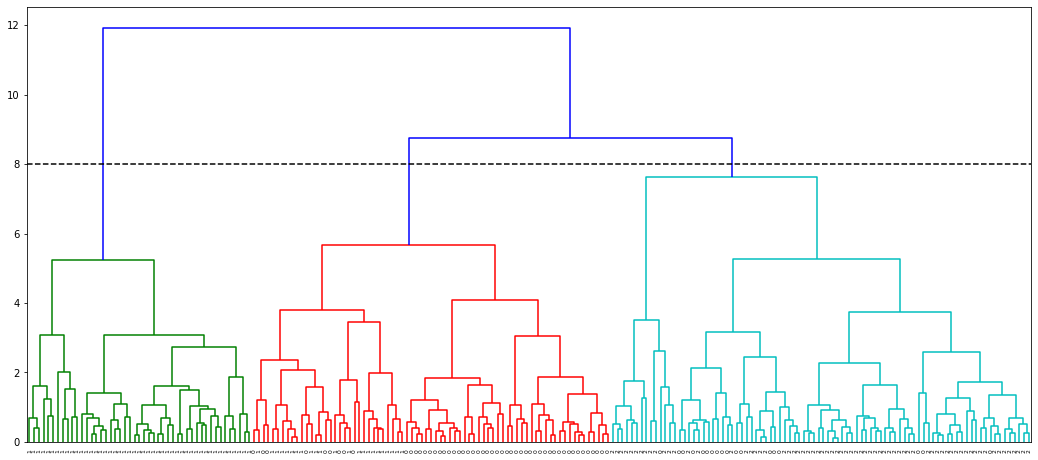

In [20]:
#Agglomerative Clustering - Fathest point distance - Dendrogram
fig, ax = plt.subplots(figsize=(18,8))
mergings = linkage(samples,method="complete")
dendrogram(mergings,
           labels=list(wheats["label"]),
           leaf_rotation=90,
           leaf_font_size=6,
)
ax.plot(ax.get_xbound(), [8,8],'--', c='k')
fig.show()

In [21]:
#Agglomerative Clustering - Farthest point distance - Clustering
agg_clus = AgglomerativeClustering(n_clusters = 3,linkage="complete")
wheat_preds["labels_agg"] = agg_clus.fit_predict(wheats[list(wheats.columns[:-1])])
pd.crosstab(wheat_preds.label_act,wheat_preds.labels_agg)

labels_agg,0,1,2
label_act,,,
0,18,0,52
1,0,47,23
2,70,0,0


Only 169 are correctly segregated (0 in labels_agg is 3,1 is 2 and 2 is 1). Let's try with standardization

In [22]:
#Agglomerative Clustering - Fathest point distance - Clustering - Standardisation
std = StandardScaler()
agg_clus = AgglomerativeClustering(n_clusters = 3,linkage="complete")
pipeline = make_pipeline(std,agg_clus)
pipeline.fit(wheats[list(wheats.columns[:-1])])
wheat_preds["labels_agg_std"] = pipeline.fit_predict(wheats[list(wheats.columns[:-1])])
pd.crosstab(wheat_preds.label_act,wheat_preds.labels_agg_std)

labels_agg_std,0,1,2
label_act,,,
0,20,2,48
1,0,66,4
2,70,0,0


184 obs are correctly clustered -  Improvement from 169 without standardisation.

Now, let's try different distance calculation method

In [23]:
#Agglomerative Clustering - Fathest point distance - Clustering - Standardisation
std = StandardScaler()
agg_clus = AgglomerativeClustering(n_clusters = 3,linkage="ward",affinity="euclidean")
pipeline = make_pipeline(std,agg_clus)
pipeline.fit(wheats[list(wheats.columns[:-1])])
wheat_preds["labels_agg_std_ward"] = pipeline.fit_predict(wheats[list(wheats.columns[:-1])])
pd.crosstab(wheat_preds.label_act,wheat_preds.labels_agg_std_ward)

labels_agg_std_ward,0,1,2
label_act,,,
0,64,4,2
1,4,66,0
2,5,0,65


Huge improvement over previous iterations. 195 are correctly grouped

We were not able to visualize K-Means or Agglomerative clustering properly because of >3 dimensions. So let's try t-SNE visualization

# t-SNE Visualization

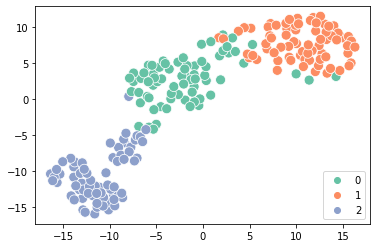

In [25]:
#t-SNE visualization - KMeans post standardisation
model = TSNE(learning_rate = 200)
tsne_features = model.fit_transform(samples)
sns.scatterplot(tsne_features[:,0],tsne_features[:,1],hue=list(wheat_preds.labels_kmeans_std),palette="Set2",s=100)
plt.legend(loc="lower right")
plt.show()

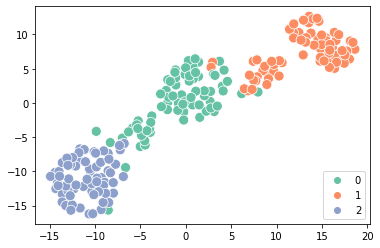

In [27]:
#t-SNE visualization - Agglomerative Clustering post standardisation
model = TSNE(learning_rate = 200)
tsne_features = model.fit_transform(samples)
sns.scatterplot(tsne_features[:,0],tsne_features[:,1],hue=list(wheat_preds.labels_agg_std_ward),palette="Set2",s=100)
plt.legend(loc="lower right")
plt.show()

We can also reduce the number of features using PCA and then visualize

# Principal Component Analysis

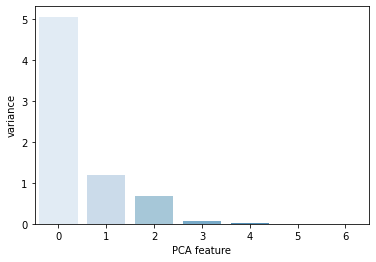

In [29]:
#PCA - Explained Variance
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler,pca)
pipeline.fit(wheats[list(wheats.columns[:-1])])
features = range(pca.n_components_)
sns.barplot(x=np.arange(0,7), y=pca.explained_variance_,palette="Blues")
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

We can see that one feature explains most of the variance and first three features explains almost 99% of the variance in the data

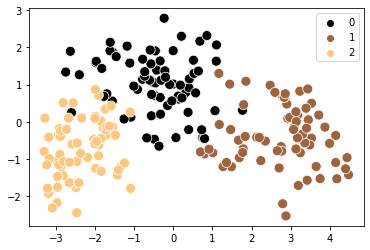

In [30]:
#PCA - Two components - Agglomerative Clustering post standardisation
pca_features = pipeline.transform(wheats[list(wheats.columns[:-1])])
sns.scatterplot(pca_features[:,0],pca_features[:,1],hue=list(wheat_preds.labels_agg_std_ward),palette="copper",s=100)
plt.show()

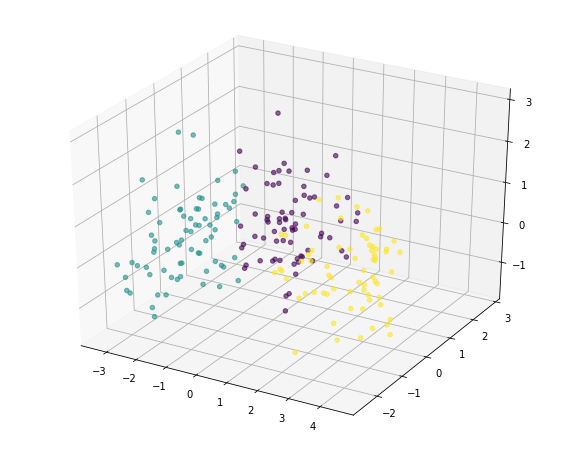

In [31]:
#PCA - Three components - K Means Clustering post standardisation
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_features[:,0],pca_features[:,1],pca_features[:,2],c=list(wheat_preds.labels_kmeans_std),alpha=0.6)
fig.show()

We can also use NMF to reduce the dimensions. The components in NMF are interpretable unlike in PCA

# Non-negative Matrix Factorization (NMF)

In [33]:
#NMF - Interpretability
model = NMF(n_components = 2,max_iter=1000)
nmf_features = model.fit_transform(wheats[list(wheats.columns[:-1])])
components_df = pd.DataFrame(model.components_,columns=list(wheats.columns[:-1]))
components_df

,A,P,C,LK,WK,A_Coef,LKG
0,12.582592,10.864008,0.595799,4.108727,2.520045,0.942989,3.903578
1,0.000000,4.443254,0.425987,1.999823,0.719236,7.099836,2.082367


First component is related to area, perimeter. Second component is related to assymetry coefficent. We can also confirm from the pairplots and heatmap in the beginning that assymetry coefficient is different from other variables

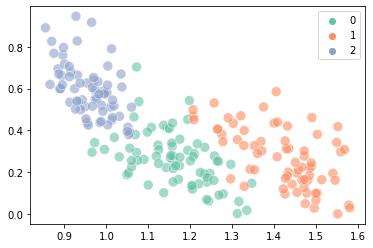

In [35]:
#NMF - Visualization
nmf = NMF(n_components = 2,max_iter=1000)
norm_features = nmf.fit_transform(wheats[list(wheats.columns[:-1])])
sns.scatterplot(norm_features[:,0],norm_features[:,1],hue=list(wheat_preds.labels_agg_std_ward),palette="Set2",alpha=0.6,s=100)
plt.show()